Nama: Tuahta Ramadhani<p>
NIM: 175150219111003

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ANALISIS SENTIMEN MASYARAKAT INDONESIA TERHADAP COVID-19 PADA MEDIA SOSIAL TWITTER MENGGUNAKAN METODE NAÏVE BAYES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import nltk
nltk.download('stopwords')

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

plt.rcParams["figure.figsize"] = [6,6]
dataset_size = 400
data_train_percentage = 0.75

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Data Collection

In [3]:
start = time.time()
tweets_csv = pd.read_csv('/content/drive/MyDrive/FILKOM UNIBRAW 2017/Teknik Informatika/SEMESTER 8/Skripsi/Program/tweets_tagged.csv', encoding="ISO-8859-1")
df = pd.DataFrame(tweets_csv) 
df = df.rename(columns={df.columns[0]: 'no_index'}) 
df.drop_duplicates(subset="tweet", keep='first', inplace=True)
df = df[:dataset_size]
df['label'] = df['label'].replace(1, "Positive").replace(2, "Negative").replace(3, "Neutral")

classes = df['label'].unique()

df

,no_index,tweet,label
0,1,Hysteria surrounding #coronavirus NZ daycare r...,Neutral
1,2,Thank you @TheOnion for dragging all of us und...,Positive
2,3,#avetmissdone is catching on faster than the #...,Positive
3,4,They just said #Tonysnell was back from the fl...,Negative
4,5,Forget locking them up on an island to die slo...,Negative
...,...,...,...
395,396,Rare breakfast chat with the kids. Todays topi...,Neutral
396,397,"EFCC, Can I DM #peruzzi #coronavirus #buhariou...",Neutral
397,398,Like kamra wishes he never sat next to Arnab ?...,Negative
398,399,Welcome to the Middle East \nDubai Corona viru...,Negative


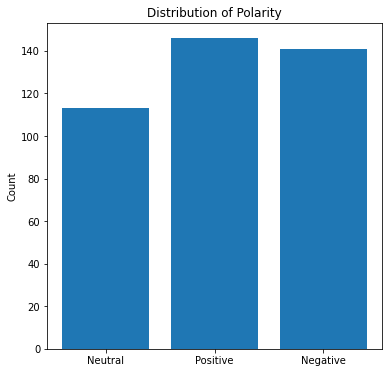

Neutral :  113
Positive :  146
Negative :  141


In [4]:
y_axis = [len(df[df["label"] == "Neutral"]), len(df[df["label"] == "Positive"]), len(df[df["label"] == "Negative"])]

plt.bar(classes, y_axis)
plt.ylabel("Count")
plt.title("Distribution of Polarity")
plt.show()

print("Neutral : ", len(df[df["label"] == "Neutral"]))
print("Positive : ", len(df[df["label"] == "Positive"]))
print("Negative : ", len(df[df["label"] == "Negative"]))

### Text Preprocessing

In [5]:
def caseFolding(text):
    text = text.lower()
    return text

df['case_folding'] = df['tweet'].apply(caseFolding)

In [6]:
def tokenizing(text):
    text = ' '.join(re.sub("[@#][A-Za-z0-9_]+|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", text).split(' '))
    text = re.sub(r"\d+", "", text)
    token = text.split()
    return token

df['tokenizing'] = df['case_folding'].apply(tokenizing)

In [7]:
stoplist = set(stopwords.words('english'))
new_stopwords = ['us','v','b','hrs','stds','lt','ards','smh','less','sms','u','w',
                 'pm','ps','p','x','k','f','r','c','ass','z','tf','gf','rt','hh',
                 'zs','n','ur','st','eu','dr','dm','ld','af','al','ed','ca',
                 'el','fr','gt','ha','im','lt','ma','my','ni','pak','per','rd','san',
                 'sat','spit','st','tc','th','tok','w','tbh','tc','amp','ba','ban',
                 'bans','bar','bo','cons','oo','dat','far','ha','inst','ke','las','mat',
                 'per','ps','red','th','tfw','tho','tic','anc','afg','efcc','ppl','t',
                 'dont','sh','uv','wa']
new_stoplist = stoplist.union(new_stopwords)

def filtering(token):
    filter_ = [t for t in token if t not in new_stoplist]
    return filter_

df['filtering'] = df['tokenizing'].apply(filtering)

In [8]:
stemmer = PorterStemmer()
def stemming(filtered_token):
    stemmed_token = [stemmer.stem(t) for t in filtered_token]
    return stemmed_token

df['stemming'] = df['filtering'].apply(stemming)

In [9]:
df.head()

,no_index,tweet,label,case_folding,tokenizing,filtering,stemming
0,1,Hysteria surrounding #coronavirus NZ daycare r...,Neutral,hysteria surrounding #coronavirus nz daycare r...,"[hysteria, surrounding, nz, daycare, requestin...","[hysteria, surrounding, nz, daycare, requestin...","[hysteria, surround, nz, daycar, request, chil..."
1,2,Thank you @TheOnion for dragging all of us und...,Positive,thank you @theonion for dragging all of us und...,"[thank, you, for, dragging, all, of, us, under...","[thank, dragging, artful, guise, satire, helpf...","[thank, drag, art, guis, satir, help, advic]"
2,3,#avetmissdone is catching on faster than the #...,Positive,#avetmissdone is catching on faster than the #...,"[is, catching, on, faster, than, the, but, no,...","[catching, faster, deaths, yet]","[catch, faster, death, yet]"
3,4,They just said #Tonysnell was back from the fl...,Negative,they just said #tonysnell was back from the fl...,"[they, just, said, was, back, from, the, flu, ...","[said, back, flu, said, shot, like]","[said, back, flu, said, shot, like]"
4,5,Forget locking them up on an island to die slo...,Negative,forget locking them up on an island to die slo...,"[forget, locking, them, up, on, an, island, to...","[forget, locking, island, die, slowly, jessica...","[forget, lock, island, die, slowli, jessica, s..."


### Corpus

In [10]:
corpus = list()
for index, row in df.iterrows():
    corpus += [word for word in row["stemming"] if word not in corpus]
corpus.sort()
corpus = np.array(corpus)
corpus_duplicate = np.unique(corpus, axis=0)
#print("Found {} words".format(corpus.shape[0]))
print("Found {} words".format(corpus_duplicate.shape[0]))

Found 1416 words


### Pembobotan Kata (Raw Term Frequency)

In [11]:
def find_tf(list_of_words):
    return [list_of_words.count(word) for word in corpus_duplicate]

tf = list()
y = list()
for index, row in df.iterrows():
    tf_val = find_tf(row["stemming"])
    tf.append(tf_val)
    y.append(row["label"])
all_features = pd.DataFrame(tf)
all_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1376,1377,1378,1379,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
396,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
397,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
398,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Data Training & Testing

In [12]:
train_size = round(dataset_size * data_train_percentage)

X_train = all_features[:train_size]
y_train = np.array(y[:train_size])
X_test = all_features[train_size:]
y_test = np.array(y[train_size:])

df_train = df[:train_size]
df_test = df[train_size:]

print("Data train size : {}".format(X_train.shape[0]))
print("Data test size : {}".format(X_test.shape[0]))

Data train size : 300
Data test size : 100


### Classification

Prior Probability

In [13]:
def make_autopct(counts):
    def my_autopct(pct):
        total = sum(counts)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

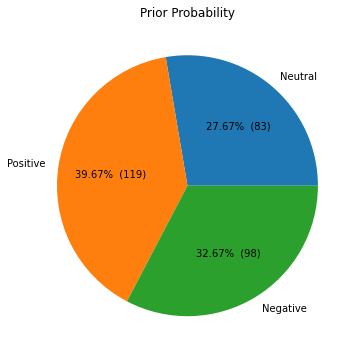

In [14]:
counts_ = dict()
count_c = dict()
prior_ = dict()
for cl in classes:
    count = np.count_nonzero(y_train == cl)
    counts_[cl] = count
    count_c[cl] = sum([X_train.loc[i].values.sum() for i in range(len(X_train)) if y_train[i] == cl])
    prior_[cl] = count / y_train.shape[0]

plt.pie(counts_.values(), labels=classes, autopct=make_autopct(counts_.values()))
plt.title("Prior Probability")
plt.show()

Likelihood Probability

In [15]:
negative = list()
neutral = list()
positive = list()
for word in corpus:
    c_neutral = 0
    c_negative = 0
    c_positive = 0
    for index, row in df.iterrows():
        if word in row["stemming"]:
            c_neutral += 1 if row["label"] == "Neutral" else 0
            c_negative += 1 if row["label"] == "Negative" else 0
            c_positive += 1 if row["label"] == "Positive" else 0
    l_neutral = ((c_neutral + 1) / (count_c["Neutral"] + corpus_duplicate.shape[0]))
    l_negative = ((c_negative + 1) / (count_c["Negative"] + corpus_duplicate.shape[0]))
    l_positive = ((c_positive + 1) / (count_c["Positive"] + corpus_duplicate.shape[0]))
    neutral.append(l_neutral)
    negative.append(l_negative)
    positive.append(l_positive)
    
data = {'Word': corpus, 'Neutral' : neutral, 'Negative' : negative, 'Positive' : positive}
likelihood_df = pd.DataFrame(data=data)
likelihood_df.drop_duplicates(subset="Word", keep='first', inplace=True, ignore_index=True)
likelihood_df

,Word,Neutral,Negative,Positive
0,aaaargh,0.000956,0.000458,0.000396
1,abar,0.000956,0.000458,0.000396
2,abarib,0.000956,0.000458,0.000396
3,accept,0.000478,0.000458,0.000791
4,accord,0.000478,0.000458,0.000791
...,...,...,...,...
1411,young,0.000478,0.000458,0.001187
1412,youtub,0.000956,0.000916,0.000396
1413,yuan,0.000478,0.000458,0.000791
1414,zahra,0.000478,0.000458,0.000791


Posterior Probability

In [16]:
docs = list()
neutral = list()
negative = list()
positive = list()
for index, row in df_test.iterrows():
    docs.append("D{}".format(index + 1))
    val_neutral = list()
    val_negative = list()
    val_positive = list()
    val_neutral.append(prior_["Neutral"])
    val_negative.append(prior_["Negative"])
    val_positive.append(prior_["Positive"])
    for word in row["stemming"]:
        row_lp = likelihood_df.loc[likelihood_df["Word"] == word]
        val_neutral.append(row_lp["Neutral"].values[0])
        val_negative.append(row_lp["Negative"].values[0])
        val_positive.append(row_lp["Positive"].values[0])
    neutral.append(np.prod(val_neutral))
    negative.append(np.prod(val_negative))
    positive.append(np.prod(val_positive))

data = {'Doc' : docs, 'Neutral' : neutral, 'Negative' : negative, 'Positive' : positive}
posterior_df = pd.DataFrame(data=data)
posterior_df

,Doc,Neutral,Negative,Positive
0,D301,2.417474e-10,3.140101e-11,4.910486e-11
1,D302,1.264339e-07,2.741936e-07,6.206855e-08
2,D303,1.264339e-07,4.112904e-07,6.206855e-08
3,D304,1.322498e-04,1.496412e-04,7.845464e-04
4,D305,3.021842e-11,6.280202e-11,2.946292e-10
...,...,...,...,...
95,D396,1.592567e-74,1.507979e-80,1.752524e-81
96,D397,6.504722e-39,3.924890e-40,1.326619e-42
97,D398,1.584266e-19,1.955948e-18,2.917860e-19
98,D399,1.901119e-18,6.374943e-18,4.559157e-20


Prediction

In [17]:
prediction_df = posterior_df.copy()
predictions = list()
for index, row in prediction_df.iterrows():
    max_ = float('-inf')
    if row["Neutral"] >= max_:
        max_ = row["Neutral"]
        max__ = "Neutral"
    if row["Negative"] >= max_:
        max_ = row["Negative"]
        max__ = "Negative"
    if row["Positive"] >= max_:
        max_ = row["Positive"]
        max__ = "Positive"
    predictions.append(max__)

predictions = np.array(predictions)
prediction_df["Actual Label"] = y_test
prediction_df["Prediction"] = predictions
prediction_df
#prediction_df.to_excel("result actual & prediction.xlsx")

,Doc,Neutral,Negative,Positive,Actual Label,Prediction
0,D301,2.417474e-10,3.140101e-11,4.910486e-11,Neutral,Neutral
1,D302,1.264339e-07,2.741936e-07,6.206855e-08,Negative,Negative
2,D303,1.264339e-07,4.112904e-07,6.206855e-08,Negative,Negative
3,D304,1.322498e-04,1.496412e-04,7.845464e-04,Positive,Positive
4,D305,3.021842e-11,6.280202e-11,2.946292e-10,Positive,Positive
...,...,...,...,...,...,...
95,D396,1.592567e-74,1.507979e-80,1.752524e-81,Neutral,Neutral
96,D397,6.504722e-39,3.924890e-40,1.326619e-42,Neutral,Neutral
97,D398,1.584266e-19,1.955948e-18,2.917860e-19,Negative,Negative
98,D399,1.901119e-18,6.374943e-18,4.559157e-20,Negative,Negative


### Evaluation

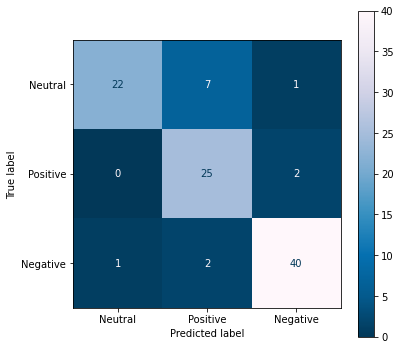

In [18]:
cm = confusion_matrix(y_test, predictions, labels=classes)
cm_display = ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap="PuBu_r", values_format='d')

In [19]:
accuracy = accuracy_score(y_test, predictions) * 100
print("Accuracy : {}%".format(accuracy))

Accuracy : 87.0%


In [20]:
cm_ = dict()
cm_["Neutral"] = {
    "TP" : cm[0][0],
    "TN" : cm[1][1] + cm[2][2],
    "FP" : cm[1][0] + cm[2][0],
    "FN" : cm[0][1] + cm[0][2],
}
cm_["Positive"] = {
    "TP" : cm[1][1],
    "TN" : cm[0][0] + cm[2][2],
    "FP" : cm[0][1] + cm[2][1],
    "FN" : cm[1][0] + cm[1][2],
}
cm_["Negative"] = {
    "TP" : cm[2][2],
    "TN" : cm[1][1] + cm[0][0],
    "FP" : cm[1][2] + cm[0][2],
    "FN" : cm[2][1] + cm[2][0],
}
cm_

{'Negative': {'FN': 3, 'FP': 3, 'TN': 47, 'TP': 40},
 'Neutral': {'FN': 8, 'FP': 1, 'TN': 65, 'TP': 22},
 'Positive': {'FN': 2, 'FP': 9, 'TN': 62, 'TP': 25}}

In [21]:
for cl in classes:
    print(cl)
    precision = cm_[cl]["TP"] / (cm_[cl]["TP"] + cm_[cl]["FP"])
    recall = cm_[cl]["TP"] / (cm_[cl]["TP"] + cm_[cl]["FN"])
    f1_measure = 2 * (precision * recall) / (precision + recall)
    specificity = cm_[cl]["TN"] / (cm_[cl]["TN"] + cm_[cl]["FP"])
    print("Precision\t: {:.3f}".format(precision))
    print("Recall\t\t: {:.3f}".format(recall))
    print("F1-Measure\t: {:.3f}".format(f1_measure))
    print("Specificity\t: {:.3f}\n".format(specificity))

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Program Excetion Run Time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Neutral
Precision	: 0.957
Recall		: 0.733
F1-Measure	: 0.830
Specificity	: 0.985

Positive
Precision	: 0.735
Recall		: 0.926
F1-Measure	: 0.820
Specificity	: 0.873

Negative
Precision	: 0.930
Recall		: 0.930
F1-Measure	: 0.930
Specificity	: 0.940

Program Excetion Run Time: 00:00:50.87
